In [1]:
import re
import nltk
import random
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 

import numpy as np
import pandas as pd
import heapq
import numpy as np
from collections import Counter
from random import sample 

In [2]:
podcasts_df = pd.read_pickle('../pickle_files/english_podcasts_detailed_cleaned.pkl')

In [3]:
podcasts_df['text'] = podcasts_df[['title', 'producer', 'genre', 'description', 'episode_titles', 'episode_descriptions']].apply(lambda x: ' '.join(x), axis=1)
podcasts_df = podcasts_df.drop(columns=['genre', 'description', 'num_episodes', 'rating', 'num_reviews', 'link', 'episode_titles', 'episode_descriptions'])
podcasts_df['ID'] = list(range(podcasts_df.shape[0]))

In [4]:
# create list of stop words
stop = get_stop_words('en')

# remove non-alphanumeric, non-space
stop = [re.sub(r'([^\s\w]|_)+', '', x) for x in stop]

# add in custom stop words
days = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']

months = ['january', 'february', 'march', 'april', 'may', 'june', 
          'july', 'august', 'september', 'october', 'november', 'december']

other = ['nan', 'podcast', 'podcasts', 'every', 'new', 'weekly', 
         'stories', 'story', 'episode', 'episodes', 'listen', 
         'host', 'hosted', 'join']

[stop.append(str(day)) for day in days]
[stop.append(str(month)) for month in months]
[stop.append(str(x)) for x in other]

def topKFrequent(tokenized_text, k): 
   
    count = Counter(tokenized_text)   
    
    return heapq.nlargest(k, count.keys(), key=count.get)

def remove_stop(text, stop):
    custom_stop = stop
#     top5 = topKFrequent(text, 5)
#     custom_stop = custom_stop + top5
    
    new_text = []
    for word in text:
        if word not in custom_stop:
            new_text.append(word)
    return new_text

# create tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# create stemmer
p_stemmer = PorterStemmer()
l_stemmer = WordNetLemmatizer() 


def stem_list(text, p_stemmer):
    new_list = []
    for word in text:
        new_list.append(p_stemmer.stem(word))
    return new_list

def lem_list(text, l_stemmer):
    new_list = []
    for word in text:
        new_list.append(l_stemmer.lemmatize(word))
    return new_list

def preprocess_text(text):
    # remove mixed alphanumeric
    text = re.sub(r"""(?x) # verbose regex
                            \b    # Start of word
                            (?=   # Look ahead to ensure that this word contains...
                             \w*  # (after any number of alphanumeric characters)
                             \d   # ...at least one digit.
                            )     # End of lookahead
                            \w+   # Match the alphanumeric word
                            \s*   # Match any following whitespace""", 
                             "", text)
    
    # remove urls (will check and remove http and www later)
    text = re.sub(r'\s([\S]*.com[\S]*)\b', '', text)
    text = re.sub(r'\s([\S]*.org[\S]*)\b', '', text)
    text = re.sub(r'\s([\S]*.net[\S]*)\b', '', text)
    text = re.sub(r'\s([\S]*.edu[\S]*)\b', '', text)
    text = re.sub(r'\s([\S]*.gov[\S]*)\b', '', text)
    
    # remove non-alphanumeric, non-space
    text = re.sub(r'([^\s\w]|_)+', '', text)
    
    # tokenize text
    text = tokenizer.tokenize(text.lower())
    
    # remove stop words
    text = remove_stop(text, stop)
    
    # stem
    text = lem_list(text, l_stemmer)
    
    # remove instances of http or www
    new_text_list = []
    for word in text:
        if re.search(r'http', word):
            continue
        if re.search(r'www', word):
            continue
        new_text_list.append(word)
    
    new_text = ' '.join(new_text_list)
    
    return new_text

In [5]:
podcasts_df['text'] = podcasts_df['text'].map(preprocess_text)
podcasts_df = podcasts_df[podcasts_df.text != '']

In [6]:
podcasts_df.head()

,title,producer,text,ID
0,History Hyenas with Chris Distefano and Yannis...,RiotCast Network,history hyena chris distefano yannis pappa rio...,0
1,Curiosity Daily,Westwood One,curiosity daily westwood one education awardwi...,1
2,Spirits,Multitude,spirit multitude history boozy mythology legen...,2
3,The Soundtrack Show,iHeartRadio,soundtrack show iheartradio tv film soundtrack...,3
4,Writing Excuses,"Brandon Sanderson, Mary Robinette Kowal, Dan W...",writing excuse brandon sanderson mary kowal da...,4


In [7]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot

In [8]:
class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [9]:
text_list = list(podcasts_df.text)
tokenized_text = [tokenizer.tokenize(i) for i in text_list]

In [10]:
w2v_model = Word2Vec(tokenized_text, sg=1)

In [32]:
model_word_list = list(w2v_model.wv.vocab)
sample_word_list = sample(model_word_list, 15)
sample_word_list

['aminooo',
 'epps',
 'worship',
 'core',
 'earthworm',
 'consolidation',
 'officially',
 'chairman',
 'kissed',
 'rally',
 'auditory',
 'thunder',
 'worked',
 'reinforcement',
 'nachrichten']

### Building Visualization

In [33]:
keys = sample_word_list

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_model.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(w2v_model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

/Users/sidd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/Users/sidd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [34]:
from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

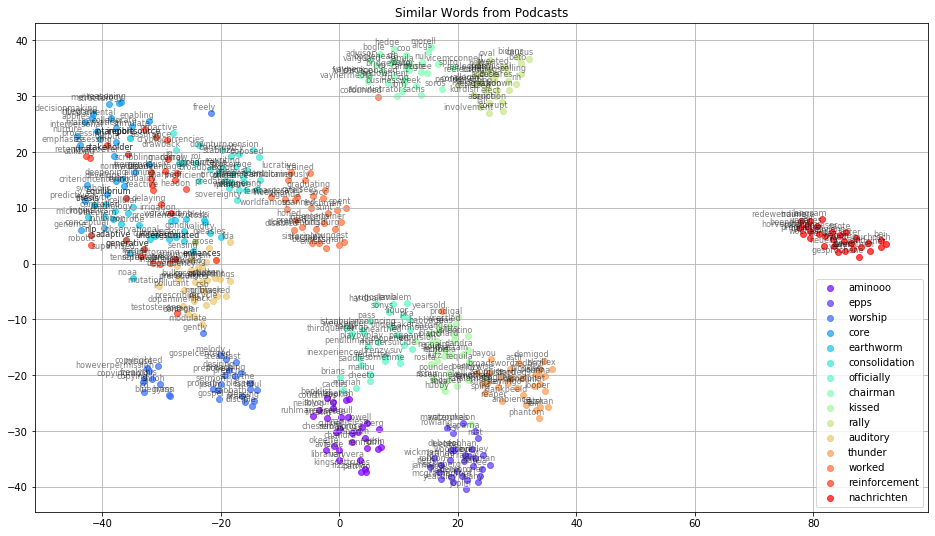

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar Words from Podcasts', keys, embeddings_en_2d, word_clusters, 0.7,
                        '../images/similar_words.png')

/Users/sidd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


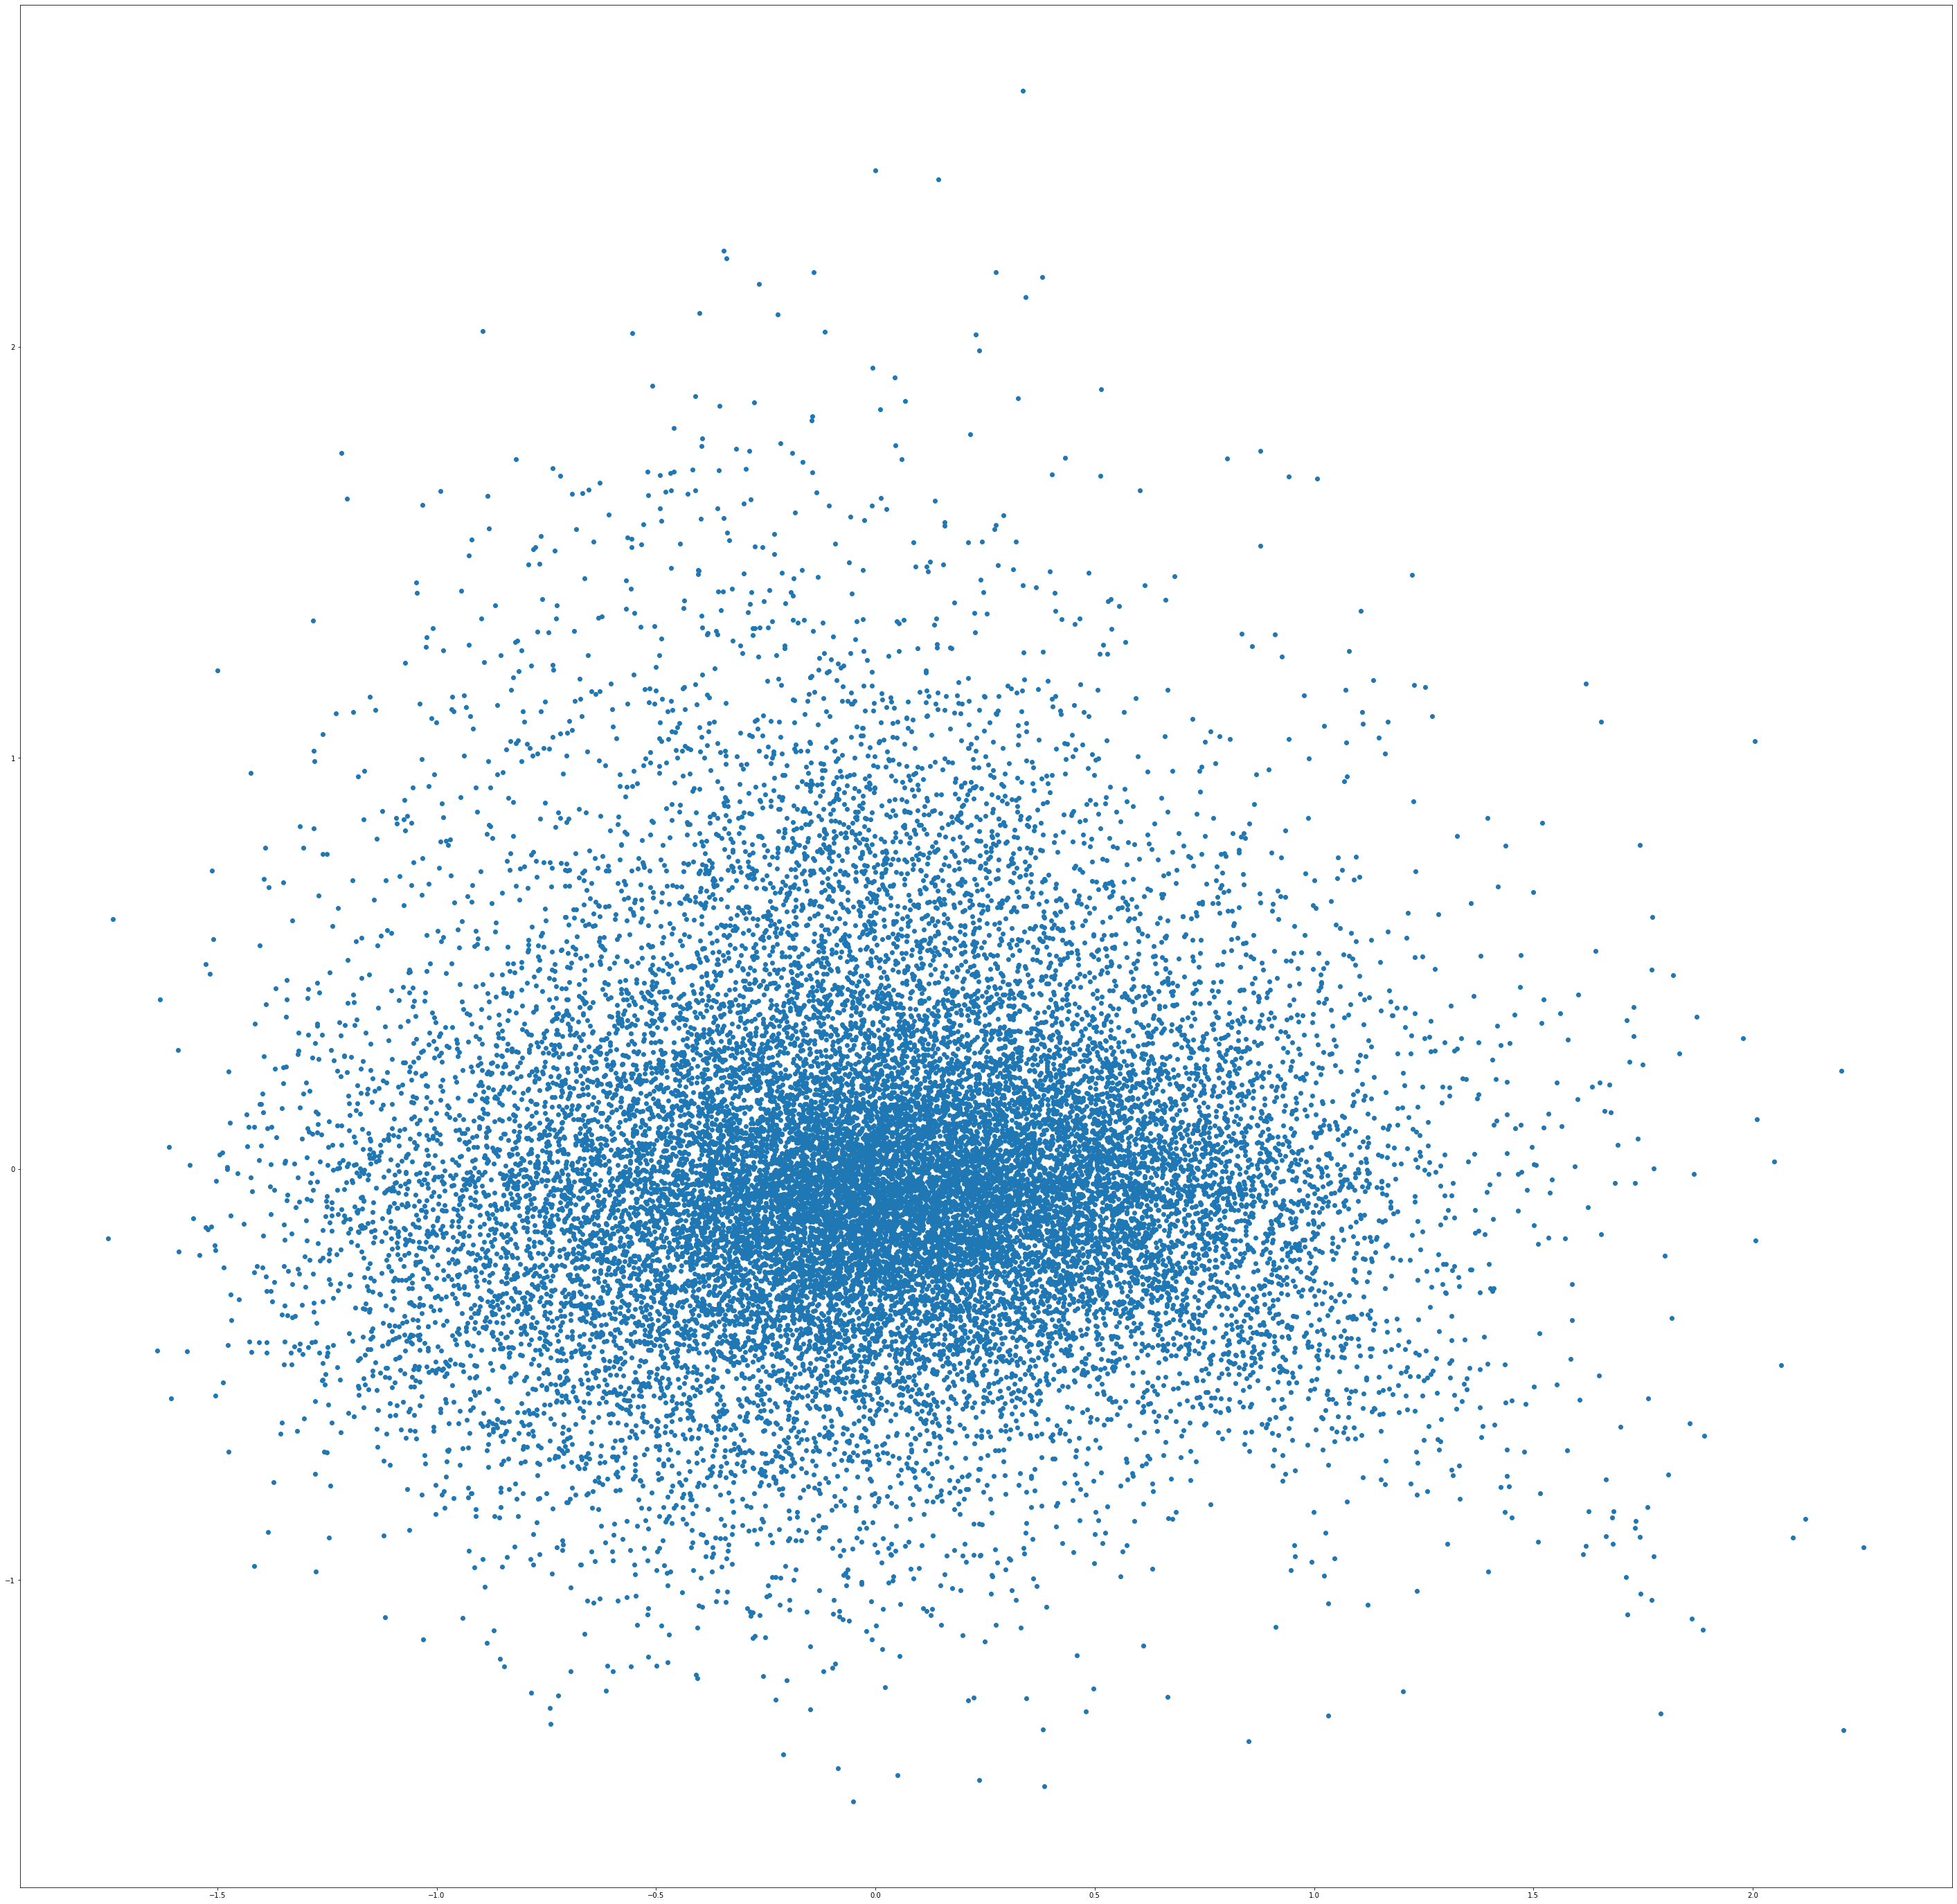

In [36]:
# fit a 2d PCA model to the vectors
X = w2v_model[w2v_model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.figure(figsize=(50, 50))
pyplot.scatter(result[:, 0], result[:, 1], alpha=1)
plt.savefig("hhh.png", format='png', dpi=150, bbox_inches='tight')
pyplot.show()